# MACHINE LEARNING I
# 
# LAB ASSIGNMENT I: CLASSIFICATION

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the FICO_Dataset.csv dataset and extract conclusions, performing several classification methods properly explained.

---

In [217]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
from neuralsens import partial_derivatives as ns
# Others
from mltools import classification_tools as CT
import math
from mltools import model_tools as MT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [218]:
warnings.filterwarnings("ignore")

---

## 1. Preparing the Dataset

First of all, we start by loading the dataset and taking a look at the first 10 rows, shape of the DataFrame and type of columns in order to understand the variables.

### STEP 1: IMPORT DATASET

In [219]:
### Load file --------------------------------------------
df2 = pd.read_csv('FICO_dataset_reduced_MOD.csv', sep = ";")
df2.head()

,RiskPerformance,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
0,1.0,55,33,84,144.0,69.0,43,20.0,23.0,83,0
1,1.0,61,0,41,58.0,0.0,67,2.0,7.0,100,0
2,1.0,67,53,24,66.0,86.0,44,9.0,9.0,100,0
3,1.0,66,72,73,169.0,91.0,57,28.0,30.0,93,0
4,1.0,81,51,132,333.0,80.0,25,12.0,12.0,100,0


In [220]:
print("Shape of the DataFrame = ", df2.shape)

Shape of the DataFrame =  (7442, 11)


As we can see, there are 11 variables. Of those 11, 10 are independent, including:

- **ExternalRiskEstimate**: A measure of borrower's riskiness based on consolidated external data sources.

- **NetFractionRevolvingBurden**: The proportion of an individual's current credit usage compared to their maximum allowed credit.

- **AverageMInFile**: The average duration, in months, of the trades in a borrower's credit file.

- **MSinceOldestTradeOpen**: The age, in months, of a borrower's oldest credit account.

- **PercentTradesWBalance**: The percentage of trades with positive balance. ?

- **PercentInstallTrades**: The percentage of a borrower's credit accounts that have fixed payment terms over a specified period.

- **NumSatisfactoryTrades**: Count of trades where a borrower has met obligations satisfactorily.

- **NumTotalTrades**: Number of Total Trades (total number of credit accounts).

- **MSinceMostRecentInqexcl7days**: Months since the last credit inquiry, ignoring the most recent week.

- **PercentTradesNeverDelq**: The percentage of a borrower's trades with no history of delinquency.

Therefore, the variable to be predicted is:

- **RiskPerformance**: Paid as negotiated flag (12-36 months). Class variable (0 or 1).

### STEP 2: CHECK OUT THE MISSING VALUES

In [221]:
### Info and type of variables & missing
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          7442 non-null   int64  
 2   NetFractionRevolvingBurden    7442 non-null   int64  
 3   AverageMInFile                7442 non-null   int64  
 4   MSinceOldestTradeOpen         7415 non-null   float64
 5   PercentTradesWBalance         7386 non-null   float64
 6   PercentInstallTrades          7442 non-null   int64  
 7   NumSatisfactoryTrades         7425 non-null   float64
 8   NumTotalTrades                7419 non-null   float64
 9   PercentTradesNeverDelq        7442 non-null   int64  
 10  MSinceMostRecentInqexcl7days  7442 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 639.7 KB


We can observe that there are several missing values. Most of them are in our response variable, so we have to delete those observations (impute values in that column could be dangerous because it will affect the results of all models). Appart from that, it is also necessary to change the type of this variable, and also we could reassign the type of the *float64* ones to *int64* but it's not mandatory.

In [222]:
### Basic removal of missing values
df = df2.dropna(subset=['RiskPerformance'], inplace=False) #Inplace for "really" elminiating the rows in the dataframe

#Check results
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          5245 non-null   int64  
 2   NetFractionRevolvingBurden    5245 non-null   int64  
 3   AverageMInFile                5245 non-null   int64  
 4   MSinceOldestTradeOpen         5218 non-null   float64
 5   PercentTradesWBalance         5189 non-null   float64
 6   PercentInstallTrades          5245 non-null   int64  
 7   NumSatisfactoryTrades         5228 non-null   float64
 8   NumTotalTrades                5222 non-null   float64
 9   PercentTradesNeverDelq        5245 non-null   int64  
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 491.7 KB


It seems that the rest of the missing values (around 100) belong to other variables. We could delete them, but we would lose information for the rest of values in the observations. So is that, we impute that missings with the k-nearest neighbors function from scikit-learn.

In [223]:
columns_with_missing_values = df.columns[df.isnull().any()].tolist()

imputer = KNNImputer(n_neighbors=10) #Number of neighbors could be changed

# Impute missing values
df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RiskPerformance               5245 non-null   float64
 1   ExternalRiskEstimate          5245 non-null   int64  
 2   NetFractionRevolvingBurden    5245 non-null   int64  
 3   AverageMInFile                5245 non-null   int64  
 4   MSinceOldestTradeOpen         5245 non-null   float64
 5   PercentTradesWBalance         5245 non-null   float64
 6   PercentInstallTrades          5245 non-null   int64  
 7   NumSatisfactoryTrades         5245 non-null   float64
 8   NumTotalTrades                5245 non-null   float64
 9   PercentTradesNeverDelq        5245 non-null   int64  
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 491.7 KB


### STEP 3: ENCODE VARIABLES

In [224]:
#There are no categorical input variables

### Convert output variable to factor
df.RiskPerformance = df.RiskPerformance.astype('category')

### Convert float64 variables to int64
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].apply(lambda x: x.astype('int64'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5245 entries, 0 to 7441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5245 non-null   category
 1   ExternalRiskEstimate          5245 non-null   int64   
 2   NetFractionRevolvingBurden    5245 non-null   int64   
 3   AverageMInFile                5245 non-null   int64   
 4   MSinceOldestTradeOpen         5245 non-null   int64   
 5   PercentTradesWBalance         5245 non-null   int64   
 6   PercentInstallTrades          5245 non-null   int64   
 7   NumSatisfactoryTrades         5245 non-null   int64   
 8   NumTotalTrades                5245 non-null   int64   
 9   PercentTradesNeverDelq        5245 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5245 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 456.0 KB


### STEP 4: PLOT THE DATA AND CHECK OUT FOR OUTLIERS

In [225]:
# Data types
df.describe()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
count,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000
mean,71.103718,34.584747,77.130219,200.537464,65.599428,34.668255,21.119161,22.823832,91.310391,2.186654
std,12.535667,29.076478,33.535254,99.076681,22.654030,17.413723,11.272021,12.206065,15.159203,4.994205
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,64.000000,9.000000,57.000000,135.000000,50.000000,22.000000,13.000000,15.000000,89.000000,0.000000
50%,72.000000,29.000000,75.000000,185.000000,67.000000,33.000000,20.000000,21.000000,97.000000,0.000000
75%,80.000000,56.000000,94.000000,259.000000,82.000000,46.000000,27.000000,30.000000,100.000000,3.000000
max,93.000000,232.000000,322.000000,604.000000,100.000000,100.000000,78.000000,100.000000,100.000000,24.000000


As we can see, there are negative values that stand out. According to the information given, there are 3 possible scenarios:

- **-9**: No Bureau Record or No Investigation.

- **-8**: No Usable/Valid Trades or Inquiries.

- **-7**: Condition not Met (e.g. No Inquiries, No Delinquencies).

Therefore, if a **-9** appears in any row, it should be replaced. Nonetheless, if we take a look at the *.csv* file, we can see that there are around 50 rows that all of the values for the independent variables are **-9**, so we can proceed by deleting those rows.

In [226]:
df = df[(df != -9).all(axis=1)]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5195 entries, 0 to 7391
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5195 non-null   category
 1   ExternalRiskEstimate          5195 non-null   int64   
 2   NetFractionRevolvingBurden    5195 non-null   int64   
 3   AverageMInFile                5195 non-null   int64   
 4   MSinceOldestTradeOpen         5195 non-null   int64   
 5   PercentTradesWBalance         5195 non-null   int64   
 6   PercentInstallTrades          5195 non-null   int64   
 7   NumSatisfactoryTrades         5195 non-null   int64   
 8   NumTotalTrades                5195 non-null   int64   
 9   PercentTradesNeverDelq        5195 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5195 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 451.6 KB


,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
count,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000,5195.000000
mean,71.874687,35.004235,77.959192,202.554187,66.317421,35.088547,21.409047,23.130125,92.275842,2.294321
std,9.812837,28.898398,32.608875,97.385605,21.541998,16.959460,10.929992,11.856607,11.585244,4.895500
min,33.000000,-8.000000,4.000000,-8.000000,-8.000000,0.000000,0.000000,1.000000,0.000000,-8.000000
25%,64.000000,9.000000,57.000000,137.000000,50.000000,22.000000,13.000000,15.000000,89.000000,0.000000
50%,72.000000,30.000000,75.000000,186.000000,67.000000,33.000000,20.000000,22.000000,97.000000,0.000000
75%,80.000000,56.000000,94.000000,260.500000,82.000000,46.000000,28.000000,30.000000,100.000000,3.000000
max,93.000000,232.000000,322.000000,604.000000,100.000000,100.000000,78.000000,100.000000,100.000000,24.000000


Besides, there are also around 50 observations (2 of them with this value repeated) in different variables having **-8** as a value. Due to the fact that this number implies that there are no valid trades, we delete those rows, as in the previous case. It could be possible also to impute them, but the few observations affected and all the work that has to be done in order to do it correctly (maybe searching for a variable with correlation to use regression or a deep understanding of the variable and its relationship with the rest of them) indicates that eliminating the rows may be a better solution.

In [227]:
df = df[(df != -8).all(axis=1)]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5145 entries, 0 to 7341
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   RiskPerformance               5145 non-null   category
 1   ExternalRiskEstimate          5145 non-null   int64   
 2   NetFractionRevolvingBurden    5145 non-null   int64   
 3   AverageMInFile                5145 non-null   int64   
 4   MSinceOldestTradeOpen         5145 non-null   int64   
 5   PercentTradesWBalance         5145 non-null   int64   
 6   PercentInstallTrades          5145 non-null   int64   
 7   NumSatisfactoryTrades         5145 non-null   int64   
 8   NumTotalTrades                5145 non-null   int64   
 9   PercentTradesNeverDelq        5145 non-null   int64   
 10  MSinceMostRecentInqexcl7days  5145 non-null   int64   
dtypes: category(1), int64(10)
memory usage: 447.3 KB


,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days
count,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000,5145.000000
mean,71.819048,35.175510,77.829155,202.413605,66.280078,35.010496,21.459475,23.181147,92.267444,2.374927
std,9.802586,28.869156,32.555655,97.201973,21.480005,16.853058,10.918579,11.851869,11.561419,4.835027
min,33.000000,0.000000,4.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-7.000000
25%,64.000000,9.000000,57.000000,137.000000,50.000000,22.000000,14.000000,15.000000,89.000000,0.000000
50%,72.000000,30.000000,75.000000,186.000000,67.000000,33.000000,20.000000,22.000000,97.000000,0.000000
75%,80.000000,56.000000,94.000000,260.000000,82.000000,46.000000,28.000000,30.000000,100.000000,3.000000
max,93.000000,232.000000,322.000000,604.000000,100.000000,94.000000,78.000000,100.000000,100.000000,24.000000


The last strange value is **-7**, which implies that the condition of the column is not met. As we can see, it only appears in the months since the most recent credit inquiry, meaning that there has never been an inquiry in that line of credit. We have again two options, but here it could be better to impute the values, because the degree of depth of understanding necessary for this and the rest of the variables is less than the previous case. 

The idea is to replace the values with an extremely (yet logical) high value, and add a binary column indicating if there has been an inquiry in the line of credit. Obviously this new variable would be used in nearly all the models of the assignment (in LDA and QDA is not possible). 

The maximum value is 24 months, so we can change all **-7** observations for **24** months. However, maybe the line of credit was opened after 24 months, so maybe it is better to convert the column into a categorical one. To prove this, we plot an histogram to observe its distribution.

Anyway, we will also change the -7 observations for 24 months in the cases it makes sense and for the maximum logical value in the rest of the cases. We do this, as in some models we will create in the future, it might be interesting to have only quantitative variables.

In [228]:
df.columns

df['MSinceMostRecentInqexcl7days'].describe()

count    5145.000000
mean        2.374927
std         4.835027
min        -7.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        24.000000
Name: MSinceMostRecentInqexcl7days, dtype: float64

In [229]:
df['MSinceMostRecentInqexcl7daysN']=df['MSinceMostRecentInqexcl7days']
     
for i in df['MSinceMostRecentInqexcl7daysN'].index:
    if df['MSinceMostRecentInqexcl7daysN'][i]==-7:
        df['MSinceMostRecentInqexcl7daysN'][i] = min(df['MSinceOldestTradeOpen'][i],24)
 

This variable 'MSinceMostRecentInqexcl7daysN' will be the one that will be used in the models that only include quantitative values

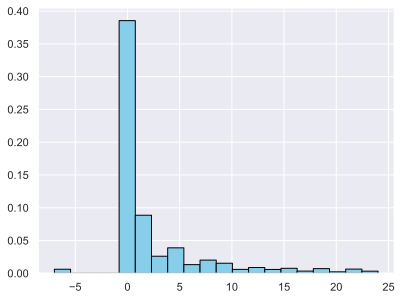

In [230]:
plt.hist(df['MSinceMostRecentInqexcl7days'], bins=20, color='skyblue', edgecolor='black', density=True)
plt.show()

We can see that the frequency is a lot higher in one or two of the values. For that reason, and bearing in mind the previous study with **-7**, we change this variable to a categorical one.

In [231]:
#Creation of the LessThan1Month dummy for future model purposes

df['lessthan1Month_num'] = 0
df.loc[df['MSinceMostRecentInqexcl7days'] < 1, 'lessthan1Month_num'] = 1

In [232]:
# Creation of the categorical variable MSinceMostRecentInqexcl7days
conditions = [
    (df['MSinceMostRecentInqexcl7days'] < 1) & (df['MSinceMostRecentInqexcl7days'] >= 0),
    (df['MSinceMostRecentInqexcl7days'] <= 6) & (df['MSinceMostRecentInqexcl7days'] >= 1),
    (df['MSinceMostRecentInqexcl7days'] <= 12) & (df['MSinceMostRecentInqexcl7days'] > 6),
    (df['MSinceMostRecentInqexcl7days'] > 12),
    (df['MSinceMostRecentInqexcl7days'] == -7)
]

choices = ['Less1Month', '1-6Months', '6-12Months', 'Greater12Months', 'Never']

df['MSinceMostRecentInqexcl7days'] = np.select(conditions, choices, default='Unknown')
df.MSinceMostRecentInqexcl7days = df.MSinceMostRecentInqexcl7days.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5145 entries, 0 to 7341
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   RiskPerformance                5145 non-null   category
 1   ExternalRiskEstimate           5145 non-null   int64   
 2   NetFractionRevolvingBurden     5145 non-null   int64   
 3   AverageMInFile                 5145 non-null   int64   
 4   MSinceOldestTradeOpen          5145 non-null   int64   
 5   PercentTradesWBalance          5145 non-null   int64   
 6   PercentInstallTrades           5145 non-null   int64   
 7   NumSatisfactoryTrades          5145 non-null   int64   
 8   NumTotalTrades                 5145 non-null   int64   
 9   PercentTradesNeverDelq         5145 non-null   int64   
 10  MSinceMostRecentInqexcl7days   5145 non-null   category
 11  MSinceMostRecentInqexcl7daysN  5145 non-null   int64   
 12  lessthan1Month_num             5145 non

After fixing all the strange values, we can proceed to plot some graphics searching for other outliers, and visualizing the distribution.

In [233]:
Independent_vars = df.columns[(df.columns != 'RiskPerformance')]
Independent_vars_cuant = df.columns[(df.columns != 'lessthan1Month_num') & (df.dtypes != 'category')]

# Definition of the rows and columns for the plot
num_rows = len(Independent_vars_cuant) // 2  #Now there are 10 cuantitative variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    axs[row, col].hist(df[var], bins=20, color='skyblue', edgecolor='black', density=True) #Number of bins could be changed
#    axs[row, col].set_title(var)
#    axs[row, col].set_xlabel('Values')
#    axs[row, col].set_ylabel('Frequency')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In the penultimate histogram we can observe a similar behaviour to the variable `MSinceMostRecentInqexcl7daysN`, but here it could be more interesting to keep this variable as a quantitative one (for future models). For that reason, we use a BoxCox transformation for both variables.

In [234]:
from scipy.stats import boxcox

df['PercentTradesNeverDelq'] = boxcox((df['PercentTradesNeverDelq'] + 0.0001))[0] #To ensure that all data is positive
df['MSinceMostRecentInqexcl7daysN'] = boxcox((df['MSinceMostRecentInqexcl7daysN'] + 0.0001))[0] #To ensure that all data is positive

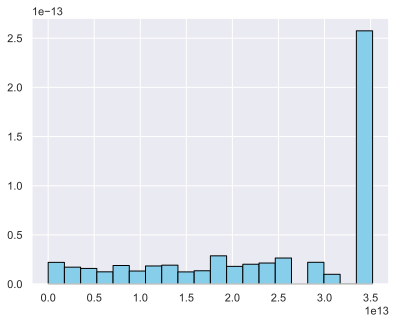

In [235]:
plt.hist(df['PercentTradesNeverDelq'], bins=20, color='skyblue', edgecolor='black', density=True)
plt.show()

This is the maximum normality we can get. Obviously it is not the desired, but we cannot use more transformations.

In the rest of the columns, we cannot see any clear outliers or strange observations. Therefore, we proceed representing several boxplots and scatterplots of the variables.

In [236]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.boxplot(x=df[var], ax=axs[row, col], color='skyblue')
#    axs[row, col].set_title(var)
#    axs[row, col].set_xlabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

As we can see, there are several outliers and most of them are skewed distributions. Nonetheless, there are not strange enough to think about replacing or deleting them. To finish things off, we represent the 2 categorical variables, in order to spot strange behaviours.

In [237]:
num_rows = 1  #2 categorical variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Loop in charge of representing histograms
#for i, var in enumerate(['RiskPerformance', 'MSinceMostRecentInqexcl7days']):
#    col = i % num_cols
#    ax = axs[col]
#    df[var].value_counts(normalize=True).plot.bar(rot=0, xlabel=var, ax=ax, ylabel ='Frequency', color = 'Skyblue')
#    ax.tick_params(axis='x', labelsize=9)

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

The results are the expected, so we can continue.

### STEP 5: EXPLORATORY ANALYSIS

First, we are going to represent a brief study between the dependent variable `RiskPerformance` and the rest of all. We have several options, such as density curves, box plots, etc. Nevertheless, we are going to plot a group of violin plots, stip plots and histogram subplots based on the response variable (box plots and density curves contain the same information as the previous ones).

In [238]:
num_rows = len(Independent_vars_cuant) // 2  #Now there are 10 cuantitative variables
num_cols = 2

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.violinplot(x='RiskPerformance', y=var, data=df, ax=axs[row, col])
#    axs[row, col].set_title(f'Violinplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel('Risk Performance')
#    axs[row, col].set_ylabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In [239]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.stripplot(x='RiskPerformance', y=var, data=df, ax=axs[row, col], jitter=True)
#    axs[row, col].set_title(f'Stripplot of {var} by Risk Performance')
#    axs[row, col].set_xlabel('Risk Performance')
#    axs[row, col].set_ylabel('Values')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

In [240]:
# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop in charge of representing histograms
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
#    sns.histplot(x=var, hue='RiskPerformance', data=df, ax=axs[row, col], kde=False, stat='probability')
#    axs[row, col].set_title(f'Histogram of {var} by Risk Performance')
#    axs[row, col].set_xlabel(var)
#    axs[row, col].set_ylabel('Frequency')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

There are not independent quantitative variables with a strong relationship with our response variable, the clearest ones might be the first four (`ExternalRiskEstimate`, `NetFractionRevolvingBurden`, `AverageMInFile` and `MSinceOldestTradeOpen`), yet being a slight dependency.

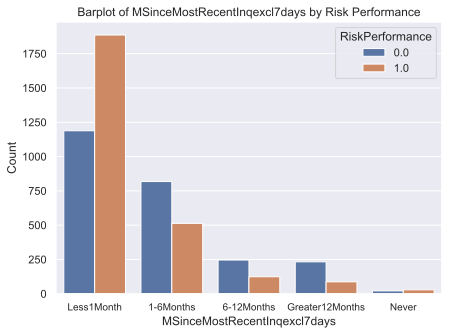

In [241]:
fig, ax = plt.subplots()
custom_order = ['Less1Month', '1-6Months', '6-12Months', 'Greater12Months', 'Never']
sns.countplot(x='MSinceMostRecentInqexcl7days', hue='RiskPerformance', data=df, order=custom_order)
ax.tick_params(axis='x', labelsize=10)
plt.xlabel('MSinceMostRecentInqexcl7days')
plt.ylabel('Count')
plt.title(f'Barplot of MSinceMostRecentInqexcl7days by Risk Performance')
plt.legend(title='RiskPerformance')

# Adjustment of design
plt.tight_layout()
# Graphic display
plt.show()

Observing the relationship between the two categorical variables we can deduce that there is a clear dependence, especially when the category is different from *Less1Month*.

In the previous section it could have been interesting to plot a pairplot, in order to spot outliers that the histograms and boxplots cannot mark. Nonetheless, with 9 quantitative variables (81 graphics), it is simply not possible to run the sentence along with the rest of the notebook. For that reason, after reviewing and searching for the most relationed variables with `RiskPerformance`, we represent a simplified pairplot.

In [242]:
# Scatterplot with the possibly most relationed variables with response
#plot = sns.pairplot(df.loc[:, ['RiskPerformance', 'ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 
#                        'MSinceOldestTradeOpen']], hue = 'RiskPerformance', height=2)
# Adjustment of design
#plt.tight_layout()
# Graphic display
#plt.show()

As we can see, there are no clear outliers, and the categories are really mixed.

The next task will be to study the possible relationship among independent variables, using a correlations plot and a pairplot, if possible. We have the same problem, so we study the pairplot for the most correlated variables.

In [243]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
#f = plt.figure()
#plt.matshow(df[Independent_vars_cuant].corr(), fignum=f.number, cmap='coolwarm')
#plt.xticks(range(df[Independent_vars_cuant].shape[1]), df[Independent_vars_cuant].columns, fontsize=14, rotation=90)
#plt.yticks(range(df[Independent_vars_cuant].shape[1]), df[Independent_vars_cuant].columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)
#plt.show()

In [244]:
# Scatterplot with the most correlated variables. To run it, uncomment subsequent lines.

#sns.pairplot(df.loc[:, ['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 'MSinceOldestTradeOpen', 
#                               'NumSatisfactoryTrades', 'NumTotalTrades']], height=2)
#plt.tight_layout()
#plt.show()

We can appreciate that nearly all of them has little or no relationship with others. However, there are a few exceptions such as:

- **NumSatisfactoryTrades VS NumTotalTrades**: It seems pretty obvious because more trades will cause more satisfactory trades.

- **AverageMInFile VS MSinceOldestTradeOpen**: Similar to the previous one. More months in file is related with the months of your oldest trade.

- **ExternalRiskEstimate VS NetFractionRevolvingBurden**: It will be reasonable to have a lower `ExternalRiskEstimate` with a higher `NetFractionRevolvingBurden`, because it is easier for that specific sector to have paying problems.

### STEP 6: CHECK OUT FOR CLASS IMBALANCES

In [245]:
# Class count
df['RiskPerformance'] = df['RiskPerformance'].replace({0: "NO", 1: "YES"}) #Not paid/paid
df['RiskPerformance'].value_counts()

RiskPerformance
YES    2639
NO     2506
Name: count, dtype: int64

As we can see, our dependent variable is nearly perfectly balanced. So is that, we can move onto the next segment.

### STEP 7: SPLIT THE DATA INTO TRAINING AND TEST SETS

We apply the methods learnt in class to split the data into training and test sets, preserving the distribution of the response variable, doing copies of the subsets to store them and creating all the lists with the possible necessary inputs.

In [246]:
# Define input and output matrices
INPUTS = df.drop(columns=['RiskPerformance']).columns.tolist()
OUTPUT = 'RiskPerformance'
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

In [247]:
X_train.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,MSinceMostRecentInqexcl7daysN,lessthan1Month_num
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,1.467896,0
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,2.657200,0
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,0.666009,0
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,0.000100,0
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,-16.491216,1


In [248]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = y_test # We will call Y as output variable for simplicity

In [249]:
INPUTS_NUM = INPUTS.copy()
INPUTS_NUM.remove('MSinceMostRecentInqexcl7days') # Exclude categorical variable in order to apply OneHotEncoder
INPUTS_NUM_NOD = INPUTS_NUM.copy()
INPUTS_NUM_NOD.remove('lessthan1Month_num') # Exclude dummy variable in order to not have collinearity 
INPUTS_NUM_NOMS = INPUTS_NUM_NOD.copy()
INPUTS_NUM_NOMS.remove('MSinceMostRecentInqexcl7daysN') # Exclude quantitative variable in order to not have collinearity
INPUTS_CAT = ['MSinceMostRecentInqexcl7days'] # ategorical variable 

## 2. Training of Machine Learning models

### MODEL 1: LOGISTIC REGRESSION

We train our model for Logistic Regression. First, we normalize the variables to eliminate any advantages between our variables, ensuring that the model can learn fairly. Then, we train the model without any penalty, allowing it to learn without any restrictions. We will train the model by including all variables as input variables. Subsequently, we will train more models to enhance the obtained results.

In [250]:
# Inputs of the model. Change accordingly to perform variable selection

INPUTS_LR = INPUTS_NUM_NOMS + INPUTS_CAT
    
# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Model pipeline
pipe = Pipeline(steps=[('Prep', preprocessor), # Preprocess the variables when training the model
                        ('LogReg', LogisticRegression(penalty=None))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 

# Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


Now, we calculate the accuracy of our model by repeating the training process 10 times and calculating the mean.

In [251]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.734944960196537

In [252]:
CT.summaryLogReg(LogReg_fit.best_estimator_, X_train[INPUTS_LR], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.991037 -0.316301  0.054695  0.310723  0.947407

Coefficients:
                                              Estimate
Intercept                                    -0.375246
ExternalRiskEstimate                         -0.631557
NetFractionRevolvingBurden                    0.358653
AverageMInFile                               -0.268919
MSinceOldestTradeOpen                         0.034107
PercentTradesWBalance                        -0.006727
PercentInstallTrades                          0.140698
NumSatisfactoryTrades                        -0.248949
NumTotalTrades                               -0.014469
PercentTradesNeverDelq                       -0.206740
MSinceMostRecentInqexcl7days_6-12Months      -0.070556
MSinceMostRecentInqexcl7days_Greater12Months -0.216202
MSinceMostRecentInqexcl7days_Less1Month       0.791322
MSinceMostRecentInqexcl7days_Never            0.466527
                                    

As we can observe in the results, the deviance residual values could be improved, as they are not close enough to zero. When examining the coefficients, we can observe that the most significant variables are ExternalRiskEstimate, NetFractionRevolvingBurden, AverageMInFile, PercentInstallTrades, NumSatisfactoryTrades, PercentTradesNeverDelq and MSinceMostRecentInqexcl7days_Less1Month.

In [253]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
### Scale test using preprocess in training

dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,MSinceMostRecentInqexcl7daysN,lessthan1Month_num,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,1.467896,0,YES,NO,0.612584,0.387416
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,2.657200,0,YES,NO,0.901065,0.098935
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,0.666009,0,NO,NO,0.704087,0.295913
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,0.000100,0,YES,YES,0.267271,0.732729
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,-16.491216,1,YES,YES,0.038554,0.961446


We now calculate the confusion matrix for the training dataset.

In [254]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1466  539
      YES  542 1569

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.95
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


We calculate the confusion matrix for the test dataset.

In [255]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_pred'],labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 340  161
      YES 130  398

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.08
Sensitivity: 0.75
Specificity: 0.68
Precision: 0.72
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.54
Balanced accuracy: 0.72
F1 Score: 0.7
Positive label: NO


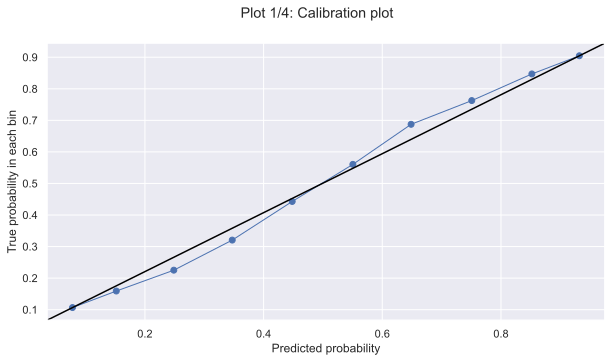

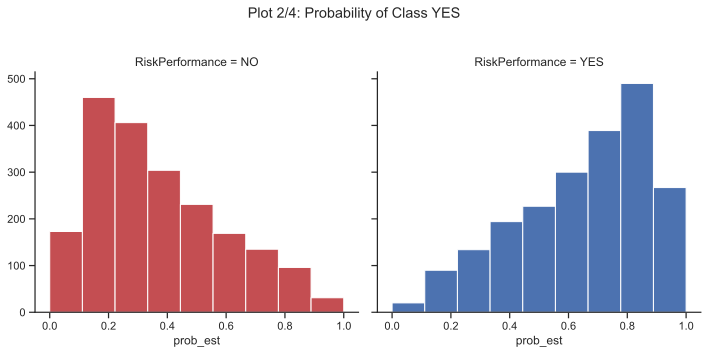

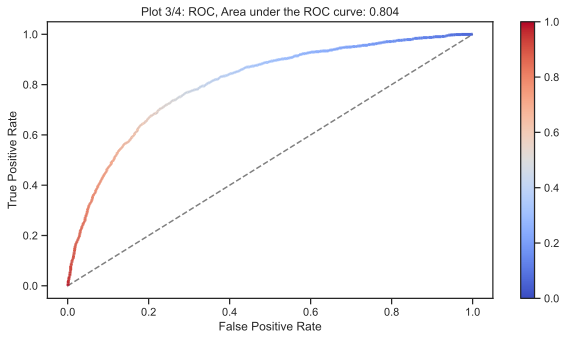

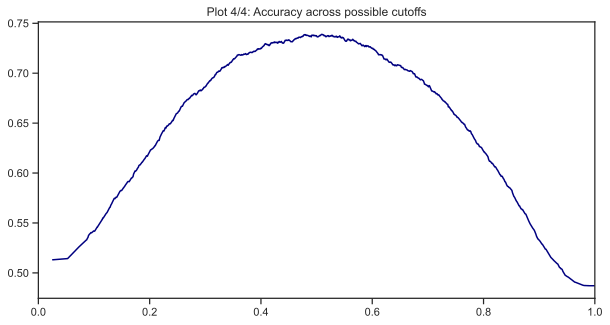

In [256]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass='YES')

As we can see in the plots, the result of this Logistic Regression model is underestimated, the ROC curve is not good enough

To improve the simplicity of our model, we will eliminate the following non-significant variables: MSinceOldestTradeOpen, PercentTradesWBalance, and NumTotalTrades. This simplification will make the model easier to understand and potentially improve its performance by reducing noise and complexity. We also removed the categorical variables except for one, 'MSinceMostRecentInqexcl7days_Less1Month.' Since the model was having trouble when removing only one of the categorical variables, we used the previously created significant variable 'lessthan1Month_num'.

In [257]:
# Inputs of the model. Change accordingly to perform variable selection

# Define input and output matrices

vars_eliminate = ['MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumTotalTrades', 'MSinceMostRecentInqexcl7daysN']
INPUTS2_LR = INPUTS_NUM.copy() # We use this subset due to the importance of the dummy Less1Month. It has been created for this model
for var in vars_eliminate:
    INPUTS2_LR.remove(var)

In [258]:
# Model pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), # Preprocess the variables when training the model
                        ('LogReg', LogisticRegression(penalty=None))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
# Train model
LogReg_fit.fit(X_train[INPUTS2_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [259]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS2_LR], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7363983180969929

In [260]:
CT.summaryLogReg(LogReg_fit.best_estimator_, X_train[INPUTS2_LR], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.991196 -0.313489  0.054907  0.310481  0.938288

Coefficients:
                            Estimate
Intercept                   0.082970
ExternalRiskEstimate       -0.637079
NetFractionRevolvingBurden  0.351350
AverageMInFile             -0.246701
PercentInstallTrades        0.138539
NumSatisfactoryTrades      -0.252938
PercentTradesNeverDelq     -0.203882
lessthan1Month_num          0.405899
                            Estimate  Std. Err    t-value      Pr(>|t|) Signif
Intercept                   0.082970  0.036725   2.259252  2.386772e-02      *
ExternalRiskEstimate       -0.637079  0.068214  -9.339376  0.000000e+00    ***
NetFractionRevolvingBurden  0.351350  0.051169   6.866484  6.580292e-12    ***
AverageMInFile             -0.246701  0.043727  -5.641842  1.682401e-08    ***
PercentInstallTrades        0.138539  0.038155   3.630954  2.823752e-04    ***
NumSatisfactoryTrades      -0.252938  0.039920  -6.336

In [261]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_2_pred'] = LogReg_fit.predict(X_train[INPUTS2_LR])
dfTR_eval['Y_LR_2_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS2_LR])[:,0]
dfTR_eval['Y_LR_2_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS2_LR])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_2_pred'] = LogReg_fit.predict(X_test[INPUTS2_LR])
dfTS_eval['Y_LR_2_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS2_LR])[:,0]
dfTS_eval['Y_LR_2_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS2_LR])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,MSinceMostRecentInqexcl7daysN,lessthan1Month_num,RiskPerformance,Y_LR_pred,Y_LR_prob_neg,Y_LR_prob_pos,Y_LR_2_pred,Y_LR_2_prob_neg,Y_LR_2_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,1.467896,0,YES,NO,0.612584,0.387416,NO,0.623078,0.376922
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,2.657200,0,YES,NO,0.901065,0.098935,NO,0.884494,0.115506
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,0.666009,0,NO,NO,0.704087,0.295913,NO,0.715017,0.284983
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,0.000100,0,YES,YES,0.267271,0.732729,YES,0.275160,0.724840
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,-16.491216,1,YES,YES,0.038554,0.961446,YES,0.038700,0.961300


In [262]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_2_pred'],labels=['NO','YES'])

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1460  545
      YES  541 1570

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.93
Sensitivity: 0.74
Specificity: 0.73
Precision: 0.73
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.51
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: NO


In [263]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_2_pred'], labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 342  159
      YES 130  398

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.44
Mcnemar's Test P-Value: 0.1
Sensitivity: 0.75
Specificity: 0.68
Precision: 0.72
Recall: 0.68
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.54
Balanced accuracy: 0.72
F1 Score: 0.7
Positive label: NO


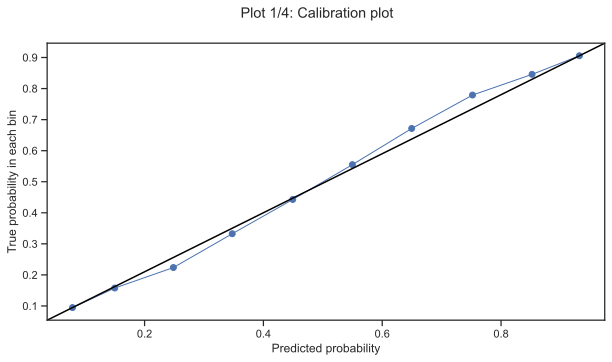

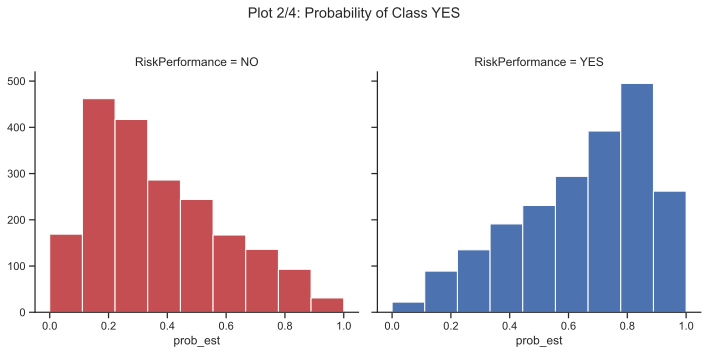

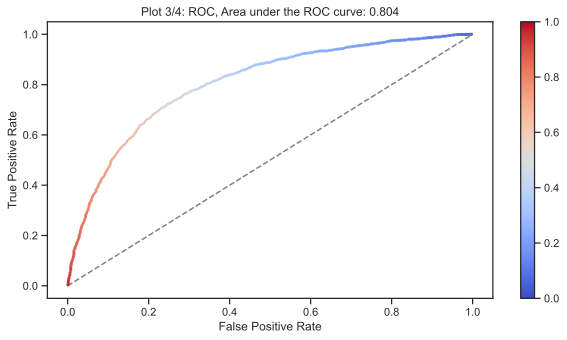

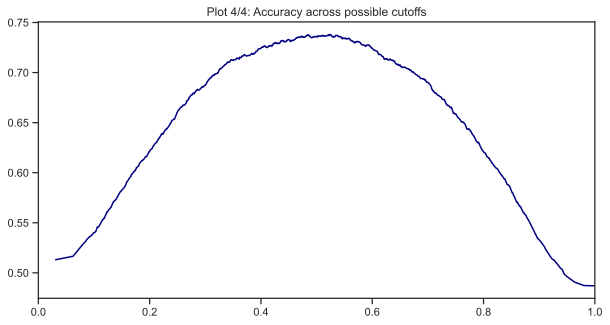

In [264]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit.predict_proba(X_train[INPUTS2_LR]), selClass='YES')

As we can observe now, the model's accuracy has improved, and the accuracy between training and test is closer. The model still has room for improvement.

Now, we selected the significant variables and convert them into numerical values. Next, we chose the 10 initial variables and included them as quadratic terms. After training the model, we observed the presence of collinearities and NaN values. Therefore, we trained a new model by selecting fewer quadratic variables and comparing the results. Finally, we obtained a model with the highest possible accuracy, and from that model, we retain only the significant variables. The following model is the result obtained. 

In [265]:
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR2_SQ = ['NumSatisfactoryTrades'] 
INPUTS_LR2_NUM = ['ExternalRiskEstimate', 'AverageMInFile', 'NetFractionRevolvingBurden', 'PercentTradesNeverDelq', 'PercentInstallTrades','lessthan1Month_num']
INPUTS_LR2 = INPUTS_LR2_NUM + INPUTS_LR2_SQ

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the numeric variables by scaling
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR2_NUM),
        ('sq', square_transformer, INPUTS_LR2_SQ), #Se aplica el square_transformer a los inputs escalares
        ])

pipe = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(fit_intercept=False, penalty=None))]) # Avoid using intercept when using polynomial features

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit_sq = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LogReg_fit_sq.fit(X_train[INPUTS_LR2], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [269]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit_sq, X_train[INPUTS_LR2], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.7381003000023623

In [270]:
CT.summaryLogReg(LogReg_fit_sq.best_estimator_, X_train[INPUTS_LR2], y_train)

Deviance Residuals:
        Min        1Q    Median        3Q      Max
0 -0.994108 -0.309023  0.046792  0.312544  0.94382

Coefficients:
                            Estimate
ExternalRiskEstimate       -0.632795
AverageMInFile             -0.242799
NetFractionRevolvingBurden  0.358968
PercentTradesNeverDelq     -0.203926
PercentInstallTrades        0.139615
lessthan1Month_num          0.403362
1                          -0.006402
NumSatisfactoryTrades      -0.336310
NumSatisfactoryTrades^2     0.096367
                            Estimate  Std. Err    t-value      Pr(>|t|) Signif
ExternalRiskEstimate       -0.632795  0.068392  -9.252514  0.000000e+00    ***
AverageMInFile             -0.242799  0.043700  -5.556072  2.759129e-08    ***
NetFractionRevolvingBurden  0.358968  0.051549   6.963651  3.315570e-12    ***
PercentTradesNeverDelq     -0.203926  0.053499  -3.811808  1.379539e-04    ***
PercentInstallTrades        0.139615  0.038328   3.642682  2.698122e-04    ***
lessthan1Month_num 

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_train[INPUTS_LR2])
dfTR_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,0]
dfTR_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_sq_pred'] = LogReg_fit_sq.predict(X_test[INPUTS_LR2])
dfTS_eval['Y_LR_sq_prob_neg'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,0]
dfTS_eval['Y_LR_sq_prob_pos'] = LogReg_fit_sq.predict_proba(X_test[INPUTS_LR2])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LR_sq_pred'],labels=['NO','YES'])

In [272]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LR_sq_pred'], labels=['NO','YES'])

----- TEST CONFUSION MATRIX-----


KeyError: 'Y_LR_sq_pred'

In [ ]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LogReg_fit_sq.predict_proba(X_train[INPUTS_LR2]), selClass='YES')

As we can see in the results, the model's accuracy improves. Also the area under the ROC curve has improved minimally. The results have generally improved, but only by a small margin.

### MODEL X: ElasticNet

Now we use the ElasticNet technique used in logistic regression to find the signficant variables. It's a combination of L1 (Lasso) and L2 (Ridge) regularization methods.

In [274]:
# Define las variables numéricas y categóricas

INPUTS_LR_E = INPUTS_NUM_NOMS + INPUTS_CAT
print(INPUTS_CAT)

# Preprocesamiento para variables numéricas (escalamiento)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Preprocesamiento para variables categóricas (codificación one-hot)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# ColumnTransformer para aplicar transformaciones a las variables correspondientes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS),
        ('cat', categorical_transformer, INPUTS_CAT)
    ])




 
param={}
print(param)
# Modelo de regresión logística con regularización Elastic Net
pipe = Pipeline(steps=[
    ('Prep', preprocessor),
    ('LogReg', LogisticRegression(penalty='elasticnet',solver="saga", max_iter=10000))  # l1_ratio controla la mezcla entre L1 y L2
])
 
    

# Entrena el modelo
pipe.fit(X_train[INPUTS_LR_E], y_train)

print("Logistic Regression with ElasticNet Trained")

['MSinceMostRecentInqexcl7days']
{}


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit_elast, X_train[INPUTS_LR_E], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
CT.summaryLogReg(LogReg_fit_elast, X_train[INPUTS_LR_E], y_train)

As we can see in the previous results, the significant variables are 'ExternalRiskEstimate,' 'NetFractionRevolvingBurden,' 'AverageMInFile,' 'PercentInstallTrades,' 'NumSatisfactoryTrades,' 'PercentTradesNeverDelq,' and 'MSinceMostRecentInqexcl7days_Less1Month.' These significant variables, obtained using ElasticNet, align with the logistic regression method conducted earlier.

### MODEL 2: DISCRIMINANT ANALYSIS (DA)

Before entering the next model prediction study (k-nn), we try another method used in prediction, but not covered in class. This method is called discriminant analysis, and it is mainly used in certain situations:

- When the response variable classes are clearly divided. In this case, logistic regression could be extremely unstable.
- If the sample size is small and the independent variables are distributed approximately as a normal, DA could be more stable.
- Thirdly, it is more used when the response variable is not dichotomous, instead of multivariable logistic regression.

Therefore, it seems a worse prediction method than the previous one, but let's check it.

Before starting, it is important to give a brief definition and explanation of its functioning. After that, we start by testing the normality of the predictors.

Discriminant Analysis is a classification technique whose objective is to obtain a function (or set) that could classify new observations by the nearest centroid and separate the classes, using a set of discriminant functions (usually linear or quadratic). It is important to point out that independency of dependent variables is recommended, as well as in most of the other methods.

In [ ]:
from scipy.stats import normaltest 

# Dictionary to store normality test results
normality_results = {}

# Check normality for each feature
for var in Independent_vars_cuant:
    normality_results[var] = normaltest(df[var]).pvalue > 0.05 #Shapiro is better for smaller samples

# normality_results dictionary will indicate whether each feature is normally distributed or not
print(normality_results)


In [ ]:
from scipy.stats import probplot

# Creation of subplots
#fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 14))

# Loop to create Q-Q plots
#for i, var in enumerate(Independent_vars_cuant):
#    row = i // num_cols
#    col = i % num_cols
    
    # Create Q-Q plot for the variable
#    probplot(df[var], plot=axs[row, col], fit=True)
    
#    axs[row, col].set_title(f'Q-Q Plot of {var}')
#    axs[row, col].set_xlabel('Theoretical Quantiles')
#    axs[row, col].set_ylabel('Sample Quantiles')

# Adjustment of design
#plt.tight_layout()

# Graphic display
#plt.show()

As we can see, the predictors are not normally distributed, neither analytically nor graphically. Therefore, the results obtained may be worse or less precise than others using K-Nearest Neighbors (KNN) or Support Vector Machine (SVM). Still, we will check the outputs.

In [ ]:
from scipy.stats import boxcox

X_DA = X.copy()

# Box-Cox transformation to the predictors 
for var in Independent_vars_cuant[(Independent_vars_cuant != 'PercentTradesNeverDelq') & 
                                  (Independent_vars_cuant != 'MSinceMostRecentInqexcl7daysN')]:
    # We add 0.0001 to ensure that they are all positive variables
    X_DA[var] = boxcox(X_DA[var] + 0.0001)[0]

# Split for normalized data. We need a new one because normalizing after the split leads to errors in the X_test data frame,
# due to the lack of observations
X_train_DA, X_test_DA, y_train, y_test = train_test_split(X_DA, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y


In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LDA = Independent_vars_cuant 

#ModLDA = LinearDiscriminantAnalysis()
pipe = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LDA',LinearDiscriminantAnalysis())]) # Model to use in the pipeline

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LDA_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
LDA_fit.fit(X_train_DA[INPUTS_LDA], y_train);

print("Linear Discriminant Analysis Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LDA_fit, X_train_DA[INPUTS_LDA], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LDA_pred'] = LDA_fit.predict(X_train_DA[INPUTS_LDA])
dfTR_eval['Y_LDA_prob_neg'] = LDA_fit.predict_proba(X_train_DA[INPUTS_LDA])[:,0]
dfTR_eval['Y_LDA_prob_pos'] = LDA_fit.predict_proba(X_train_DA[INPUTS_LDA])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LDA_pred'] = LDA_fit.predict(X_test_DA[INPUTS_LDA])
dfTS_eval['Y_LDA_prob_neg'] = LDA_fit.predict_proba(X_test_DA[INPUTS_LDA])[:,0]
dfTS_eval['Y_LDA_prob_pos'] = LDA_fit.predict_proba(X_test_DA[INPUTS_LDA])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
#Confusion matrix for Linear Discriminant Analysis
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LDA_pred'],labels=['NO','YES'])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LDA_pred'], labels=['NO', 'YES'])

In [ ]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], LDA_fit.predict_proba(X_train_DA[INPUTS_LDA]), selClass='YES')

The results are pretty similar to logistic regression (a little bit worse unless the test's specificity), indicating that probably none of them is good enough to predict our response variable. We now try using quadratic discriminant analysis, searching for better results.

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_QDA = Independent_vars_cuant 

#ModQDA = QuadraticDiscriminantAnalysis()
pipe = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('QDA',QuadraticDiscriminantAnalysis())]) # Model to use in the pipeline

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
QDA_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                            param_grid=param, # Defined grid to search in
                            n_jobs=-1, # Number of cores to use (parallelize)
                            scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                            cv=nFolds) # Number of Folds 
#Train model
QDA_fit.fit(X_train_DA[INPUTS_QDA], y_train);

print("Quadratic Discriminant Analysis Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(QDA_fit, X_train_DA[INPUTS_QDA], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_QDA_pred'] = QDA_fit.predict(X_train_DA[INPUTS_QDA])
dfTR_eval['Y_QDA_prob_neg'] = QDA_fit.predict_proba(X_train_DA[INPUTS_QDA])[:,0]
dfTR_eval['Y_QDA_prob_pos'] = QDA_fit.predict_proba(X_train_DA[INPUTS_QDA])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_QDA_pred'] = QDA_fit.predict(X_test_DA[INPUTS_QDA])
dfTS_eval['Y_QDA_prob_neg'] = QDA_fit.predict_proba(X_test_DA[INPUTS_QDA])[:,0]
dfTS_eval['Y_QDA_prob_pos'] = QDA_fit.predict_proba(X_test_DA[INPUTS_QDA])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
#Confusion matrix for Quadratic Discriminant Analysis Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_QDA_pred'],labels=['NO','YES'])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_QDA_pred'], labels=['NO', 'YES'])

In [ ]:
CT.plotClassPerformance(dfTR_eval['RiskPerformance'], QDA_fit.predict_proba(X_train_DA[INPUTS_QDA]), selClass='YES')

We observe that the results are even worse, especially for the classification of *NO* class in `RiskPerformance`. Moreover, the Mcnemar's Test P-Value = 0.0 for both training and test, indicating that at least one model from CV has significantly different errors with the others, so it is not valid. Besides, we observe that in both models they have clearly higher values for sensitivity, and we are not interested in giving one of them more importance than the other.

### MODEL 3: K-NEAREST NEIGHBORS (KNN)

We move on to training a K-Nearest-Neighbours Model. The idea behind this algorithm is quite simple, however there are going to be a few characteristics of it that we need to work with carefully.

A KNN classification model works the following way. Let´s suppose we have a new observation that needs to be classified and for which the values of the independent variables in the model are known(we name those values x), the algorithm will simply calculate which are the K observations that are closer(by default using euclidean distance) to him in the space of our predictors. 

After it, it reads the amount of neighbours that belong to each class and using that for example, the number of neighbors that belong to the class j is n$_j$,calculates the probability that our new observation belongs to class j like: P(Y$_i$=j|X$_i$=x)=$\frac{n_j}{K}$ 

As we mentioned before, the idea of the algorithm is quite simple compared to Logistic Regression or Discriminant Analysis, whereas, in the previous models we have studied, there was no hyperparameter to consider, unlike this time,where we will need to calculate(through CV) the number of neighbours that will turn out to produce the most accurate model we can get.

Considering the amount of data we have and the low complexity of the algorithm, we are able to perform a pretty exhaustive search of the parameter. The first look will be to check values for K that stand between 9 and 559 with steps of 10, and in case we obtain that the optimal K is about 559, then we will consider bigger values than 559. All these values will be odd as this way we avoid draws between the 2 classes of our dependent variable. 

The other hyperparameter that takes part in the model is the number of folds we use in the CV, but for the whole document we keep this value in 10 folds. We move on to training our model using KNN. 

The explanation of why we have decided to use the numerical form of the variable MSinceMostRecentInqexcl7days is detailed in the report, and as we want to keep the code short and straight to the point of analyzing the results each model delivers, we won´t give a detailed explanation here.
But, in few words, the KNN algorithm requires the definition of a distance between categories when working with categorical variables, and the definition of these distances felt artificial for us. So, considering that we have a a numerical form of this variable, in which these same distances are naturally defined, we choose to use the numeric variable. 

In [57]:
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_KNN = INPUTS.copy()
INPUTS_KNN.remove('MSinceMostRecentInqexcl7days')

INPUTS_KNN=INPUTS_KNN + ['MSinceMostRecentInqexcl7daysN'] 

X = df[INPUTS_KNN]

# Split again including the numeric variable
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

 
random_seed = 0  # Puedes cambiar este número si deseas otra semilla
np.random.seed(random_seed)


## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(9,559,10)} #Number of neighbors
 
# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier( ))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds,
                      ) # Number of Folds 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("kNN Trained")
 

kNN Trained


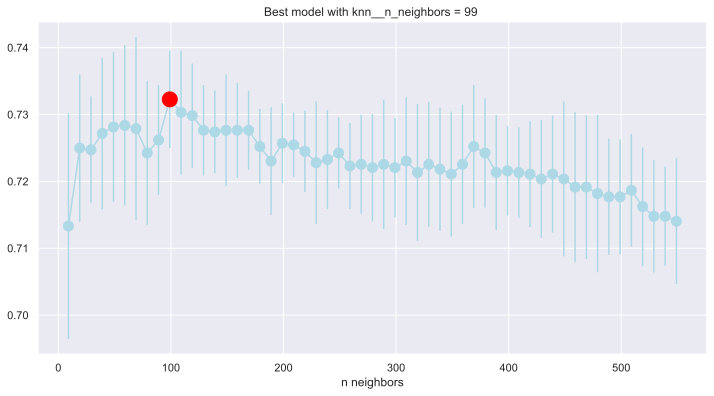

In [58]:
MT.plotModelGridError(knn_fit)

In [126]:
print("Best parameters found:")
print(knn_fit.best_params_)
print("CV accuracy:")
print(knn_fit.best_score_)


Best parameters found:
{'knn__n_neighbors': 99}
CV accuracy:
0.7322661989464484


As we can see, we obtain that the optimal KNN model considers 99 neighbors, which feels like a pretty reasonable value considering the amount of data, and obtains an accuracy of 73.22%.In the plot it can also be seen a trend of a decrease in the accuracy as the number of neighbors grows from 99, so it does not feel necessary to try higher values for the hyperparameter K.   
The results don´t differ much from the ones obtained in the previous models, yet we still need to calculate the test set Accuracy.

In [66]:

dfTR_KNN_eval = X_train.copy()
dfTR_KNN_eval['RiskPerformance'] = y_train # We will call Y as output variable for simplicity
dfTS_KNN_eval = X_test.copy()
dfTS_KNN_eval["RiskPerformance"] = y_test # We will call Y as output variable for simplicity

## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_KNN_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_KNN_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_KNN_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_KNN_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_KNN_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_KNN_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

      ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
7070                    72                          33             100   
4049                    86                           0             112   
3664                    73                          14              81   
3008                    60                          76              54   
6137                    57                          98              30   
...                    ...                         ...             ...   
2661                    79                          66              91   
3536                    68                          75              55   
6248                    85                           1             109   
6348                    66                          23              94   
2352                    66                          49              96   

      MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
7070                    216        

In [63]:
CT.confusion_matrix(dfTR_KNN_eval['RiskPerformance'], dfTR_KNN_eval['Y_knn_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1508  497
      YES  603 1508

Accuracy: 0.73
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.47
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.71
Specificity: 0.75
Precision: 0.71
Recall: 0.75
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.49
Balanced accuracy: 0.73
F1 Score: 0.73
Positive label: NO


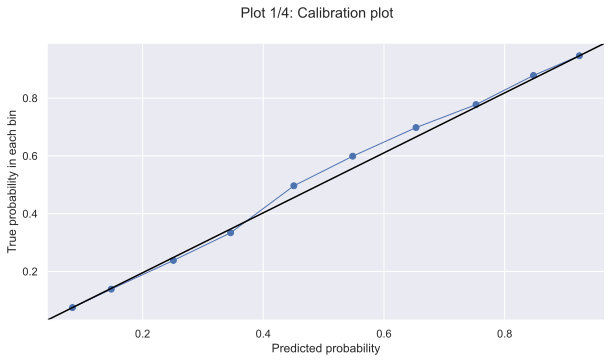

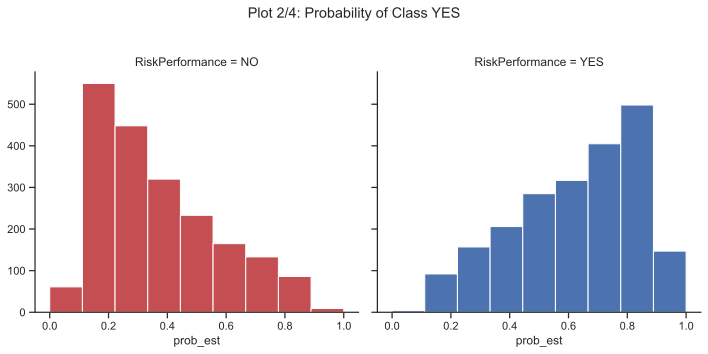

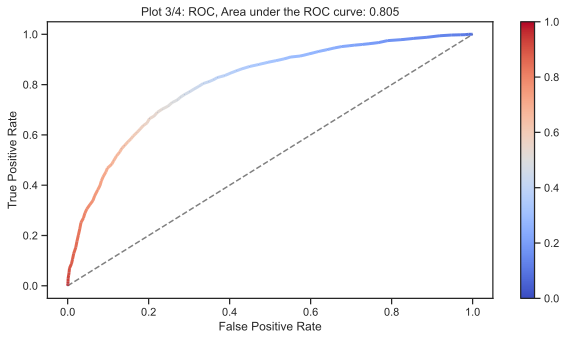

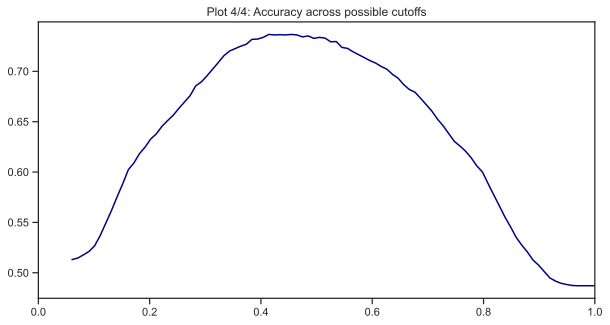

In [64]:
CT.plotClassPerformance(dfTR_KNN_eval['RiskPerformance'],knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass='YES')

Just like happened with the previous models, we obtain a quite calibrated model with about 0.805 AUC and 73%  Training Accuracy, with balanced sensitivity and specificity.

At least, these are the values we obtain while training our model and testing it with CV, yet we still need to check how good does the model performs with our test dataset. However, as we trained our model using CV, we expect the results not to differ too much.

In [69]:
 

CT.confusion_matrix(dfTS_KNN_eval['RiskPerformance'], dfTS_KNN_eval['Y_knn_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 359  142
      YES 151  377

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.64
Sensitivity: 0.71
Specificity: 0.72
Precision: 0.7
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.37
Detection prevalence: 0.5
Balanced accuracy: 0.72
F1 Score: 0.71
Positive label: NO


We can see how the accuracy, sensitivity and specificity go down a bit compared to the training results, yet it is just enough to conclude that this KNN does not seem like the best model we can reach.

Even though we won´t implement it, we thought of 2 possible options to make the KNN model more efficient and accurate.

1. It must be said that, unlike Logistic Regression, KNN´s algorithm does not work towards selecting which variables are most relevant for the model, it gives every variable the same importance. Due to that, using variable selections like the one Logistic Regression´s p-values or Decision Trees provide, the algorithm would probably deliver better results.

2. KNN, the way we implemented it, gives the same importance to the closest neighbour of a new observation as to its 99th closest neighbor. This characteristic may not be optimal, so it could be an option to add weights to each of the neighbors depending on its distance to the observation we are trying to predict, would likely be an improvement for the model.

### MODEL 4: DECISION TREES

After KNN, we are going to implement a slightly more complex model, a decision tree. 

A detailed explanation of the idea behind the algorithm that builds a Decision Tree model is shown in the report.
For the decision trees we are going to develop, we are going to try and optimize the hyperparameter that represents the impurity a node needs to have to be allowed to split. A higher value of this parameter will turn out in smaller and more simple trees as nodes will tend to split less, so we will have less divisions in our trees, and exactly the opposite will happen for smaller values.

Besides that, we will control the size of the tree stablishing values such as the minimum number of observations in a terminal node, in order to avoid overfitting. We will start by using all the predictors in the data set, and we will use the categorical form of MSinceMostRecentInqexcl7days.

In [109]:
INPUTS_DT_NUM = INPUTS_LR.copy()
INPUTS_DT_NUM.remove('MSinceMostRecentInqexcl7days')
INPUTS_DT_CAT = ['MSinceMostRecentInqexcl7days']
INPUTS_DT = INPUTS_DT_NUM + INPUTS_DT_CAT

['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance', 'PercentInstallTrades', 'NumSatisfactoryTrades', 'NumTotalTrades', 'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']


In [110]:
# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply different transformers to the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, INPUTS_DT_NUM),
        ('cat', categorical_transformer, INPUTS_DT_CAT)
    ])

# Define the parameter grid for Grid Search
param = {'DT__min_impurity_decrease': np.arange(0, 0.08, 0.001)}

# Create the Decision Tree pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply data preprocessing
    ('DT', DecisionTreeClassifier(criterion='gini',
                                  min_samples_split=5,
                                  min_samples_leaf=5,
                                  random_state=0))
])

# Use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe,
                       param_grid=param,
                       n_jobs=-1,
                       scoring='accuracy',
                       cv=nFolds)
tree_fit.fit(X_train, y_train)  # Train the model

print("DT Trained")

DT Trained


Bigger values have been tried for the hyperparameter, using values from 0.1 to 0.25 but the results were absolutely inaccurate, so they won´t be shown.
We focus in smaller values with a maximum of 0.08.
 

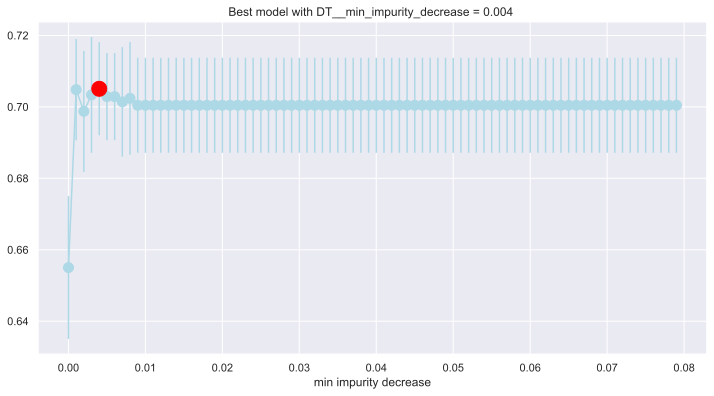

In [111]:
MT.plotModelGridError(tree_fit)

In [129]:
print("Best parameters found:")
print(tree_fit.best_params_)
print("CV accuracy:")
print(tree_fit.best_score_)


Best parameters found:
{'DT__min_impurity_decrease': 0.004}
CV accuracy:
0.7050646068079276


We can see that in the best possible case for the minimum impurity decrease parameter, the training results are worse than the ones seen in the previous models. However, the important measure will be how the model behaves in the test samples, which we will check later. Prior to it, we show the optimal tree obtained, important graphic as it shows a key measure of which are the most important variables in the model.  

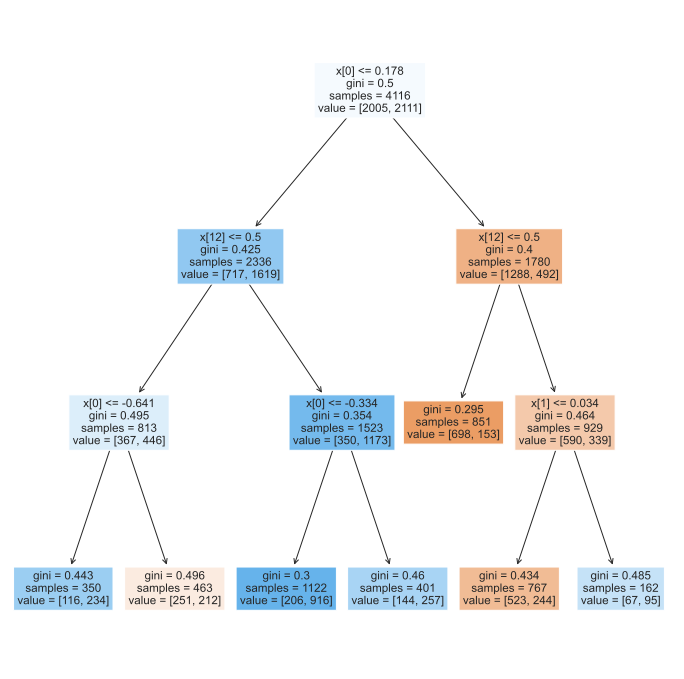

In [148]:
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

The decision tree shows how the first two variables in X(ExternalRiskEstimate,NetFractionRevolvingBurden), along with one of the categories of MSinceMostRecentInqexcl7days, which is the category of LessThanOneMonth(we saw its significance in Logistic Regression) are the most important variables in the model. It also stands out that the tree seems a little too simple considering the amount of variables and observations, and the last plot shows how the amount of samples in the terminal nodes is at times, even bigger than a 1000, which usually translates into high levels of impurity in the nodes.

However, we tried smaller values for the minimum impurity decrease obtaining worst models, so it feels like increasing the complexity does not help in this case. Even though we may get no improvement, we will try afterwards to change some parameters in order to increase the complexity of the trees a little bit.



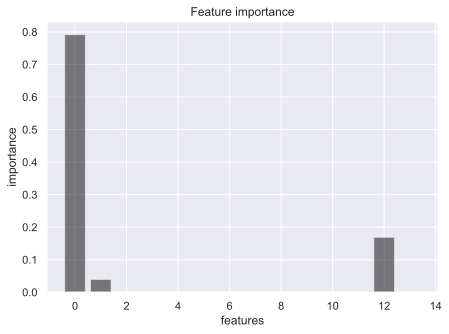

In [114]:
index = np.arange(len(X_train[INPUTS_DT].columns)+4)

bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.tight_layout()
plt.show()

The graphic shows what we mentioned earlier about the 3 most important variables, being the 12th variable the category LessThanOneMonth. Now, we obtain the confusion matrix of our training for the optimal tree obtained, and check how the tree predicts new observations with our test dataset.

In [115]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,MSinceMostRecentInqexcl7daysN,lessthan1Month_num,RiskPerformance,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,1.467896,0,YES,NO,0.542117,0.457883
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,2.657200,0,YES,NO,0.820212,0.179788
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,0.666009,0,NO,NO,0.542117,0.457883
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,0.000100,0,YES,YES,0.331429,0.668571
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,-16.491216,1,YES,YES,0.183601,0.816399


In [116]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_DT_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1472  533
      YES  609 1502

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.45
Mcnemar's Test P-Value: 0.03
Sensitivity: 0.71
Specificity: 0.73
Precision: 0.71
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.36
Detection prevalence: 0.49
Balanced accuracy: 0.72
F1 Score: 0.72
Positive label: NO


In [128]:
 CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_DT_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 346  155
      YES 158  370

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.39
Mcnemar's Test P-Value: 0.91
Sensitivity: 0.7
Specificity: 0.69
Precision: 0.69
Recall: 0.69
Prevalence: 0.51
Detection Rate: 0.36
Detection prevalence: 0.51
Balanced accuracy: 0.7
F1 Score: 0.69
Positive label: NO


This tree gives us a 70% of accuracy in the test observations, which is a lower value than the one obtained in some of the previous models, so this tree turns out to be meaningless for us. As we mentioned earlier, we try to improve these results by increasing the complexity of the trees. 

In order to achieve this increase in the trees complexity, we are going to change the optimization criteria from Gini to Entropy. The Gini measure is defined in a way that it tries to minimize the probability of getting a classification wrong, unlike the entropy, with which the tree only tries that its nodes are as pure as possible, what means that it tries that each node only contains observations of one category, what tends to mean that the trees will be more complex.

We could see that the number of samples in each terminal node was much bigger than 5 in every case so we won´t touch the other 2 parameters as it is unlikely that they have any effect in the model. The rest of parameters that can be considered in the decision tree implementation are defined by default in a way that they tend to make the model as complex as needed. For example, there is a parameter with which you can control the maximum depth of the tree, and it is defined by default to None, what means that the tree can be as deep as needed. Due to this, we do not define any other parameter of the DecisionTreecLassifier function. 


In [117]:
param = {'DT__min_impurity_decrease': np.arange(0, 0.08, 0.001)}

# Create the Decision Tree pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply data preprocessing
    ('DT', DecisionTreeClassifier(criterion='entropy',
                                  min_samples_split=5,
                                  min_samples_leaf=5,
                                  random_state=0))
])

# Use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit_en = GridSearchCV(estimator=pipe,
                       param_grid=param,
                       n_jobs=-1,
                       scoring='accuracy',
                       cv=nFolds)
tree_fit_en.fit(X_train, y_train)  # Train the model

print("DT Trained")

DT Trained


In [130]:
# Obtain Cross-Validation score
print("Best parameters found:")
print(tree_fit_en.best_params_)
print("CV accuracy:")
print(tree_fit_en.best_score_)


Best parameters found:
{'DT__min_impurity_decrease': 0.006}
CV accuracy:
0.7057927621477335


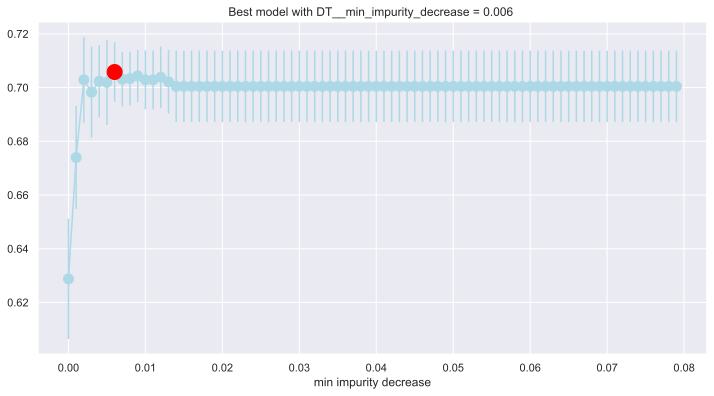

In [119]:
MT.plotModelGridError(tree_fit_en)

We obtain a similar value for the accuracy and a bigger value for the minimum impurity decrease, so it feels like the model is compensating the increase of complexity we established by changing the optimization criteria with an equivalent increase of our complexity hyperparameter. 

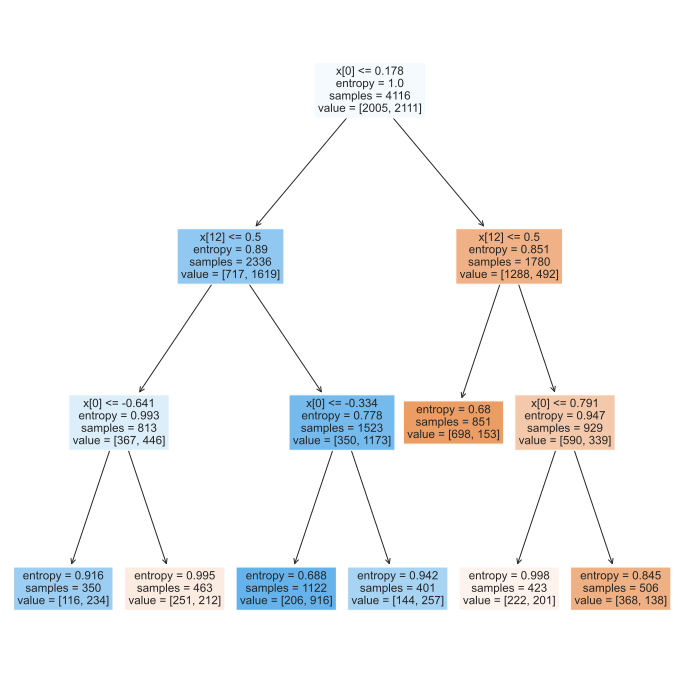

In [120]:
plt.figure(figsize=(12, 12))
plot_tree(tree_fit_en.best_estimator_['DT'], filled=True)
plt.show()

As we mentioned earlier, we obtain an almost identical tree, in fact, we checked it and about 3100 of the observations are predicted the same probailities of YES with both models. So it feels like a more complex tree tends to return worse values somewhy, so the CV optimization discards it. Let´s check the confusion matrix this tree returns to see if it behaves better in the test dataset than our previous tree.

In [121]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT2_pred'] = tree_fit_en.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT2_prob_neg'] = tree_fit_en.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT2_prob_pos'] = tree_fit_en.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT2_pred'] = tree_fit_en.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT2_prob_neg'] = tree_fit_en.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT2_prob_pos'] = tree_fit_en.predict_proba(X_test[INPUTS_DT])[:,1]



#visualize evaluated data
dfTS_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,MSinceMostRecentInqexcl7daysN,lessthan1Month_num,RiskPerformance,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos,Y_DT2_pred,Y_DT2_prob_neg,Y_DT2_prob_pos
3501,62,75,70,155,100,57,21,23,4.027002e+12,Less1Month,-16.491216,1,YES,YES,0.183601,0.816399,YES,0.183601,0.816399
7125,60,13,59,172,86,69,9,13,1.126085e+12,1-6Months,1.280404,0,YES,YES,0.331429,0.668571,YES,0.331429,0.668571
6575,80,23,62,116,83,23,24,26,3.522006e+13,Less1Month,-16.491216,1,NO,NO,0.681877,0.318123,NO,0.727273,0.272727
2983,58,55,18,29,90,45,10,11,1.785671e+13,Less1Month,-16.491216,1,YES,YES,0.183601,0.816399,YES,0.183601,0.816399
5181,60,40,23,49,90,31,16,16,3.522006e+13,Less1Month,-16.491216,1,YES,YES,0.183601,0.816399,YES,0.183601,0.816399


In [123]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_DT2_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1539  466
      YES  704 1407

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.67
Specificity: 0.77
Precision: 0.69
Recall: 0.77
Prevalence: 0.51
Detection Rate: 0.34
Detection prevalence: 0.46
Balanced accuracy: 0.72
F1 Score: 0.72
Positive label: NO


In [124]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_DT2_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 368  133
      YES 178  350

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.4
Mcnemar's Test P-Value: 0.01
Sensitivity: 0.66
Specificity: 0.73
Precision: 0.67
Recall: 0.73
Prevalence: 0.51
Detection Rate: 0.34
Detection prevalence: 0.47
Balanced accuracy: 0.7
F1 Score: 0.7
Positive label: NO


The value for the accuracy is again 0.7, so we do not get any improvement at all, however, if we observe carefully, this tree has an interesting property. The value of the specificity is one of the highest obtained in all of the models we traines, what means that these model is good predicting those clients who are not going to pay their debt.

It feels more logical to try and be accurate predicting those clients that are not going to pay, so this concrete characteristic of the tree is valid for us, however, as the accuracy is one of the lowest obtained, the model is pretty likely to be discarded.

### MODEL 5: RANDOM FOREST

We have struggled to increase the complexity of our decision tree by changing its parameters, what has meant that we did not get any improvement on the accuracy at all respect to the previous models trained.
 
This does not necessarily mean that decision trees are useless for our concrete case, as there are a bag of techniques that can be applied to them in order to get more complex, hence more accurate(in this case) models. One of those techniques is random forest.

Random Forest is a technique that consists on the training of multiple trees that only consider a given number m among all the variables in the dataset, which are selected randomly for each tree trained. Let´s say that we establish m=5 and number_of_trees=50. Random Forest will train 50 models, choosing 5 variables of our dataset randomly, and for each observation in the train dataset, each tree will give a prediction for the category of the response.

For each observation, it will be considered how many of the 50 predictions were a YES and how many were a NO, and the category that repeats the most will be our final prediction. Random Forest is a way more powerful model than a simple decision tree, however it implies that we need to take care of 3 parameters, those being the number m of variables considered, the number of trees to create and the minimal impurity decrease value.

In order to simplify the implementation of the model and reduce the dimensionality by one, we are going to define what we consider an appropiate value for m=6. This way, we only need to take care about the optimization of 2 parameters, and the difference of the model with values of m=3,4,5,7 would not be too significant.

In [140]:
 
INPUTS_RF = INPUTS_DT

# Definir los parámetros que deseas optimizar
param = {
    'RF__n_estimators': range(10, 200, 10),  # Number of trees 
    'RF__min_impurity_decrease': np.arange(0.02,0.1,0.01)  
}

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('RF', RandomForestClassifier(
        criterion='gini',  # Impurity measure
        max_features=6,  # Number of variable to choose randomly for the training of each tree
        min_samples_split=5,  # Minimum samples in a node for it to be allowed to split
        min_samples_leaf=5,  # Minimum nuber of samples in a terminal node
        random_state=0 
    ))
])

# GridSearchCV is carried out on order to optimize the hyperparameters in the model
nFolds = 10
rf_fit = GridSearchCV(
    estimator=pipe,  
    param_grid=param,  # Hyperparameters grid
    n_jobs=-1,  
    scoring='accuracy',  
    cv=nFolds  # Number of divisions (folds)
)

rf_fit.fit(X_train[INPUTS_RF], y_train)  

print("Random Forest Trained")

Random Forest Trained


In [141]:
print("Best parameters found:")
print(rf_fit.best_params_)
print("CV accuracy:")
print(rf_fit.best_score_)


Best parameters found:
{'RF__min_impurity_decrease': 0.02, 'RF__n_estimators': 60}
CV accuracy:
0.7072502539390074


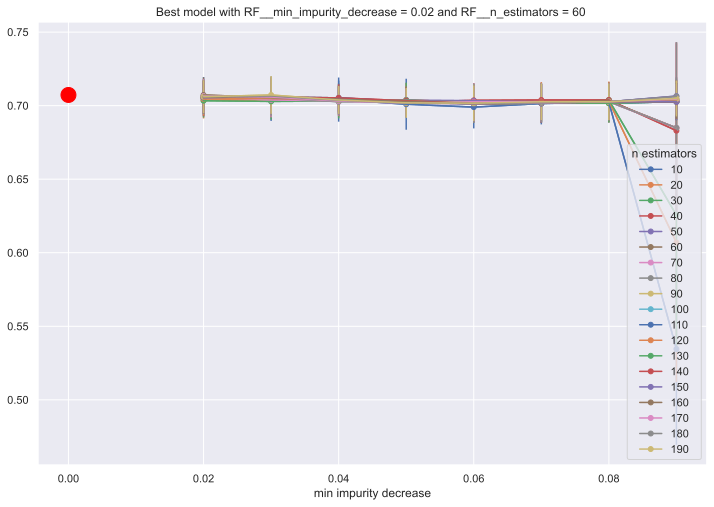

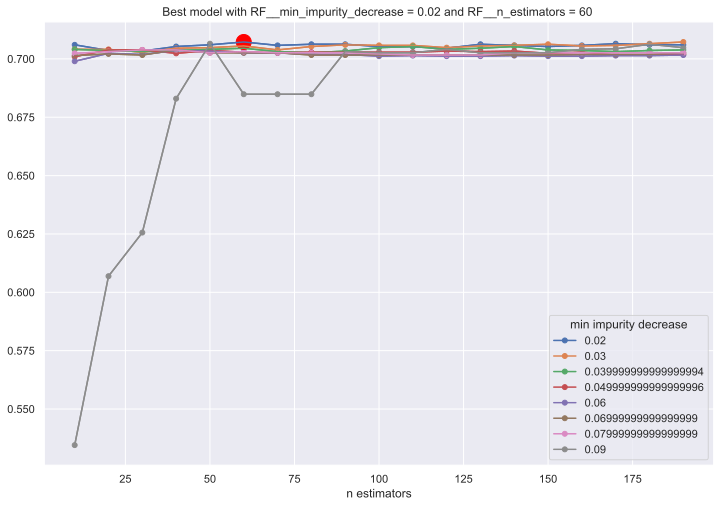

In [143]:
MT.plotModelGridError(rf_fit)

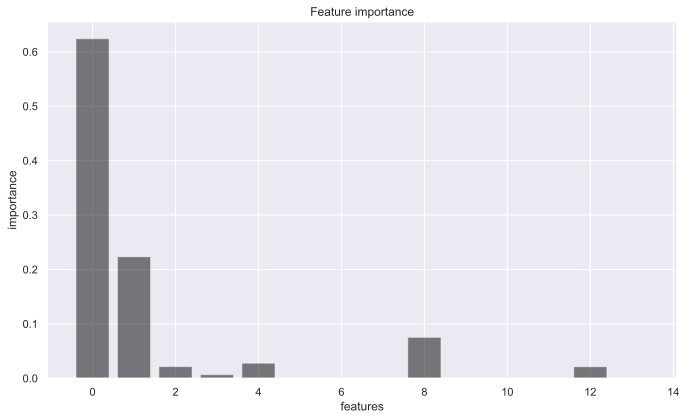

In [142]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_RF].columns)+4)
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.tight_layout()
plt.show()

The CV accuracy obtained is slightly better than in the single decision tree model, and it improves to 70.72%.

The optimal parameters have been 60 trees ensembled and a value of 0.02 for the minimal impurity decrease for splitting.The graphic shows a pretty uniform accuracy through the different values of both parameters, however, bigger values for the parameters were tested, obtaining the same optimal couple, so these results are not shown.

In the graphics we can also see how some more variables do have some importance, unlike in the decision tree model, what is explained by the property of random forest, of picking randomly the variables with which to create each tree. The variable ExternalRiskEstimate remains as the most important one and NetFractionRevolvingBurden as the second one, however, the variable that represents the category LessThanOneMonth, loses relevance compared to the previous model.
Now, we are going to check if the random forest model also improves compared to the decision tree model in the test dataset.

In [144]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train[INPUTS_RF])
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test[INPUTS_RF])
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,1]

dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,...,RiskPerformance,Y_DT_pred,Y_DT_prob_neg,Y_DT_prob_pos,Y_DT2_pred,Y_DT2_prob_neg,Y_DT2_prob_pos,Y_RF_pred,Y_RF_prob_neg,Y_RF_prob_pos
7070,72,33,100,216,31,31,25,26,1.092590e+13,1-6Months,...,YES,NO,0.542117,0.457883,NO,0.542117,0.457883,YES,0.451503,0.548497
4049,86,0,112,238,33,35,22,23,2.434181e+13,Greater12Months,...,YES,NO,0.820212,0.179788,NO,0.820212,0.179788,NO,0.692349,0.307651
3664,73,14,81,277,64,36,32,36,1.931905e+13,1-6Months,...,NO,NO,0.542117,0.457883,NO,0.542117,0.457883,NO,0.531909,0.468091
3008,60,76,54,168,71,25,33,37,7.721268e+12,1-6Months,...,YES,YES,0.331429,0.668571,YES,0.331429,0.668571,YES,0.301383,0.698617
6137,57,98,30,61,100,67,9,9,1.521567e+13,Less1Month,...,YES,YES,0.183601,0.816399,YES,0.183601,0.816399,YES,0.284627,0.715373


In [145]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_RF_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO 1331  674
      YES  524 1587

Accuracy: 0.71
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.42
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.75
Specificity: 0.66
Precision: 0.72
Recall: 0.66
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.55
Balanced accuracy: 0.71
F1 Score: 0.69
Positive label: NO


In [146]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_RF_pred'], labels=['NO','YES'])

Confusion Matrix and Statistics
	   Prediction
Reference  NO  YES
       NO 335  166
      YES 135  393

Accuracy: 0.71
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.41
Mcnemar's Test P-Value: 0.08
Sensitivity: 0.74
Specificity: 0.67
Precision: 0.71
Recall: 0.67
Prevalence: 0.51
Detection Rate: 0.38
Detection prevalence: 0.54
Balanced accuracy: 0.71
F1 Score: 0.69
Positive label: NO


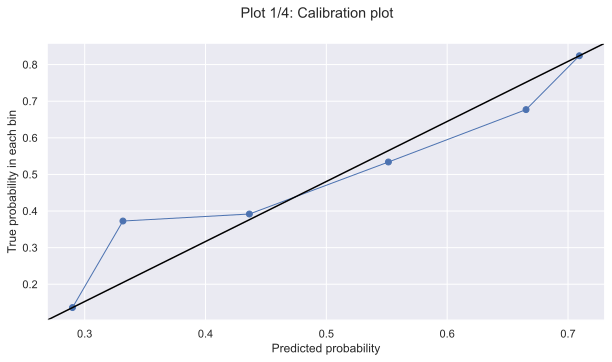

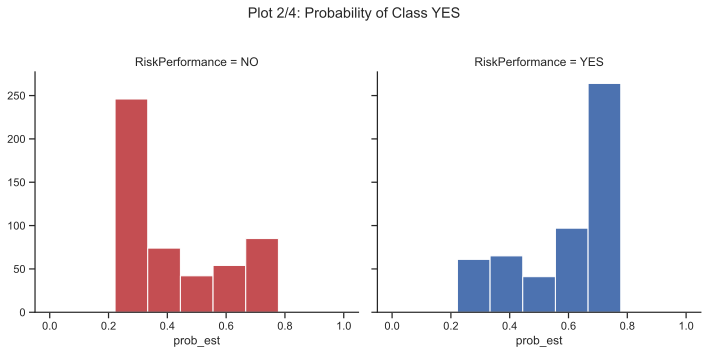

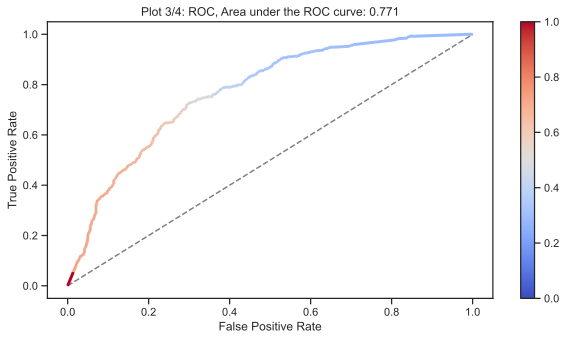

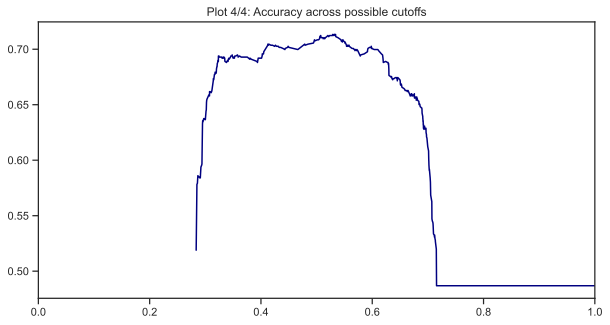

In [147]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], rf_fit.predict_proba(X_test[INPUTS_RF]), selClass='YES')

We obtain a 71% of accuracy with a 74% of sensitivity and a 67 % of specificity, what means that the model is better predicting the customers that will pay their debt than to predict the ones who won´t, a poor property for our models, considering the main aim of the bank, which is to avoid non-payments. Graphics also show us that the model is slighty worse calibrated than some of the previous ones such as KNN or logistic regression, and its AUC is slightly worse with a value of 0.771.

The improvement in the accuracy compared with the decision tree model is almost inexistent, and the results are also worse in general than the ones obtained in KNN or L.Regression, so it feels like random forest is not the optimal model for classifying in this concrete dataset.

### MODEL 6: SUPPORT VECTOR MACHINES (SVM)

The next model that we are going to implement will be Support Vector Machines. This classification algorithm performs well with only two classes, and using a kernel different from the linear on non-linear classification problems can be the key to find a correct model.

For that reason, we could use a grid to change between different cost terms (a lower cost term means that less errors are permitted: narrow margins that are rarely violated). Before showing the results, it seems that we need a higher C cost term in order to have a more biased classifier but with lower variance. It is important to indicate that we will use the selection of variables commented above, due to the fact that results are better and the interpretation is simpler.

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LSVC = INPUTS_NUM_NOMS + INPUTS_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Cost term (We have proved that lower and higher cost terms are worse)
param = {'SVC__C': np.logspace(start=np.log10(0.001), stop=np.log10(0.1), num=5)} 

pipe = Pipeline(steps=[('Prep', preprocessor), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=0))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5 # With 10 folds the execution time collapses
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
Linear_SVC_fit = CalibratedClassifierCV(
                        base_estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

print("Linear SVM Model Trained")

In [ ]:
MT.plotModelGridError(Linear_SVC_fit.base_estimator, xscale="log")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=5, scoring='accuracy').mean()

In [ ]:
## Plot the variable coefficient of each feature
plt.figure(figsize=(5 * 1.618, 5))
index = np.arange(len(X_train[INPUTS_LSVC].columns) + 3) #Add the dummies from the categorical variable
bar_width = 0.35
plt.bar(index, Linear_SVC_fit.base_estimator.best_estimator_['SVC'].coef_[0,:], color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of features')
plt.tight_layout()
plt.show()

The accuracy results are not much better than the previous models and the most important variables are similar to the rest, highlighting the first ones and some of the categories for `MSinceMostRecentInqexcl7days`.

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_train[INPUTS_LSVC])
dfTR_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,0]
dfTR_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_test[INPUTS_LSVC])
dfTS_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,0]
dfTS_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_LSVC_pred'], labels=['NO','YES'])

In [ ]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_LSVC_pred'], labels=['NO','YES'])

In [ ]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC]), selClass='YES')

The results obtained indicate that, due to the rate between the computation power needed and the resulting model, there are better, easier and faster methods to classify the response variable. Nevertheless, maybe a more complex and non-linear kernel will help in our duty, bearing in mind that it will be harder to control the overfitting.

Therefore, we develop the same model with a radial kernel instead, searching for better accuracy. In this case, we will need a higher C value searching for less overfitted models (accepting more errors) and an intermediate gamma value.

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RSVC = INPUTS_NUM_NOMS + INPUTS_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories and dropping the first category
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_NOMS), # Apply the numeric_transformer to numeric inputs
        ('cat', categorical_transformer, INPUTS_CAT) # Apply the categorical_transformer to categorical inputs
        ])

# Cost term and gamma (We have proved that the optimal is located in a high C value: near 1 and a gamma around (0.01, 0.1))
param = {'SVC__C': [0.01,0.1, 1, 2, 5], # Cost term
         'SVC__gamma':[0.001,0.01,0.1, 1, 2]} # Inverse width parameter in the Gaussian Radial Basis kernel 

pipe = Pipeline(steps=[('Prep', preprocessor), 
                        ('SVC',  SVC(kernel='rbf', # radial kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=0))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5 # With 10 folds the execution time collapses
Radial_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Radial_SVC_gcv.fit(X_train[INPUTS_RSVC], y_train) # Search in grid

print("Radial SVM Model Trained")

In [ ]:
MT.plotModelGridError(Radial_SVC_gcv, xscale="log", xscale2='log')

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_SVC_pred'] = Radial_SVC_gcv.predict(X_train[INPUTS_RSVC])
dfTR_eval['Y_SVC_prob_neg'] = Radial_SVC_gcv.predict_proba(X_train[INPUTS_RSVC])[:,0]
dfTR_eval['Y_SVC_prob_pos'] = Radial_SVC_gcv.predict_proba(X_train[INPUTS_RSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = Radial_SVC_gcv.predict(X_test[INPUTS_RSVC])
dfTS_eval['Y_SVC_prob_neg'] = Radial_SVC_gcv.predict_proba(X_test[INPUTS_RSVC])[:,0]
dfTS_eval['Y_SVC_prob_pos'] = Radial_SVC_gcv.predict_proba(X_test[INPUTS_RSVC])[:,1]

dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_SVC_pred'], labels=['NO','YES'])

In [ ]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_SVC_pred'], labels=['NO','YES'])

In [ ]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], Radial_SVC_gcv.predict_proba(X_test), selClass='YES')

The presented plots and confusion matrices indicate that the prediction is worse than expected, being slightly better than the linear kernel with a lot higher level of computer power demand and execution time. We could observe that neither the first or the second model have serious issues with overfitting, suggesting that maybe it is the best accuracy we could get for the exercise.

### Multi-Layer Perceptron (MLP)

The next model that we are going to implement will be a Multilayer Perceptron (MLP) neural network. This neural network architecture is versatile and can handle both binary and multi-class classification problems. By configuring the network with non-linear activation functions and appropriate architecture, it can effectively address non-linear classification tasks.

To develop the model, we input all variables as inputs, including the categorical variable, but in numeric format to prevent errors that were arising in the model. Once the model was trained, we modified the number of hidden layers, the number of neurons, and the alpha until reaching the optimal configuration and representing it appropriately.

In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
# Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP = INPUTS_NUM_NOD

#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------

param = {'MLP__alpha': [1e-3, 5, 8], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,), (5,1), (5,3)]} # Number of neurons in each hidden layer, enters as tuples
#param = {'MLP__alpha': [0], # L2 regularization term 
#         'MLP__hidden_layer_sizes':[(20,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function adam para cuando pete 
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=0,
                                             verbose = True))]) # For replication
 
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

print("MLP Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(MLP_fit, X_train[INPUTS_MLP], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
MT.plotModelGridError(MLP_fit, xscale="log")

As can be seen in the graph, the optimal value for alpha is 5, and the number of hidden layers is 5 neurons with a single hidden layer.

In [ ]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_.named_steps['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [ ]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)

In [ ]:
sensmlp.summary()

In [ ]:
sensmlp.info()

In [ ]:
sensmlp.plot()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,1]

### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_MLP_pred'], labels=['NO','YES'])

In [ ]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_MLP_pred'], labels=['NO','YES'])

In [ ]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass='YES')

Como podemos observar en los resultados el nivel de precisión es similar al del resto de modelos, con un area bajo la curva ROC similar al igual